In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import netCDF4
from erddapy import ERDDAP
import json

Configure the ERDDAP to search

In [2]:
ra = 'caricoos'

with open('utils/ra_erddaps.json') as f:
    urls = json.load(f)

server = urls[ra.lower()]

print(server)

e = ERDDAP(server=server, protocol="tabledap")

http://dm3.caricoos.org:8002/erddap


Pull in the processed inventory

In [3]:
#
# df_cruise = df[df['Station Description'] == 'Chesapeake Bay WQ Cruise Data ']
#
#df_aws = df[df['Station ID'] == 'Humboldt']
# #url = 'http://tds.glos.us/thredds/dodsC/buoy_agg_standard/OMOECC_E1/OMOECC_E1.ncml'
# #url = 'http://tds.glos.us/thredds/dodsC/buoy_agg_standard/45186/45186.ncml'
# #url = 'http://tds.glos.us/thredds/dodsC/buoy_agg_standard/bgsusd2/bgsusd2.ncml'
# url = 'http://oos.soest.hawaii.edu/thredds/dodsC/hioos/nss/ns12agg'
# print(url)
# ds = xr.open_dataset(url)
# #ds = netCDF4.Dataset(url,'r')
# title = ds.title
# start_time = np.datetime_as_string(ds.time.min().values, unit='D')
# end_time = np.datetime_as_string(ds.time.max().values, unit='D')
# print('Duration: %s - %s' % (np.datetime_as_string(ds.time.min().values, unit='D'),
#                              np.datetime_as_string(ds.time.max().values, unit='D'))
#       )

# Try glos web server
# url = 'https://glbuoys.glos.us/tools/export?ftype=csv&data_type=buoy&units=eng&locs=OMOECC_E1&params=Water_Temperature_at_Surface|dissolved_oxygen_saturation|water_conductivity|ysi_turbidity&tperiod=custom&date_start=2020-01-01&date_end=2020-12-31&avg_ivld=none'
# df = erddapy.ERDDAP.to_pandas(url)

## using ERDDAP to look for stations
# check out http://data.glos.us/erddap/tabledap/allDatasets.htmlTable?datasetID%2Ctitle%2CminTime%2CmaxTime&maxTime%3E=2020-01-01&maxTime%3C=2020-12-31&orderBy(%22maxTime%22)
# that lists out all the GLOS stations with the maximum time of observations within the year 2020 (on their ERDDAP).

df = pd.read_excel('2021/data/processed/%s.xlsx' % ra.upper(), dtype=str)
df

,Station ID,WMO ID or NWS/CMAN ID,Station Long Name,Station Description,Latitude (dec deg),Longitude (dec deg),Platform Type,"Station Deployment (mm/yyyy, yyyy, < 5 yr, > 5 yr)","Currently Operational? (Y, N, O, U)",Platform Funder/Sponsor,"RA Funding Involvement (Yf, Yp, N)",Platform Operator/Owner,Operator Sector,Platform Maintainer,Data Manager,"Variable Names + water column depth of measurement in meters [CF_name (# m, # m) or CF_name (mult) or CF_name (# depths)].",Additional notes,CARICOOS Contact (Name and Email),RA/Federal Affiliation
0,PR1,42085,Ponce Buoy,NaN,17.8687,-66.532,Moored buoy,06/2009 - present,Operational,CARICOOS,Yf,Neil Pettigrew/CARICOOS,Academia,CARICOOS/University of Maine,"Department of Physical Oceanography, School of...","sea_water_speed (2.5 - 16) m, sea_water_to_dir...",NaN,Julio Morell \n(julio.morell@upr.edu),CARICOOS
1,PR2,41053,San Juan Buoy,NaN,17.4743,-66.0994,Moored buoy,07/2010 - present,Operational,CARICOOS,Yf,Neil Pettigrew/CARICOOS,Academia,CARICOOS/University of Maine,"Department of Physical Oceanography, School of...","sea_water_speed (2.5 - 29) m, sea_water_to_dir...",NaN,Julio Morell \n(julio.morell@upr.edu),CARICOOS
2,PR3,41056,Vieques Buoy,NaN,18.2609,-65.464,Moored buoy,09/2013 - present,Operational,CARICOOS,Yf,Neil Pettigrew/CARICOOS,Academia,CARICOOS/University of Maine,"Department of Physical Oceanography, School of...","sea_water_speed (2.5 - 28 m), sea_water_to_dir...",NaN,Julio Morell \n(julio.morell@upr.edu),CARICOOS
3,VI1,41052,St. John Buoy,NaN,18.2491,-64.7637,Moored buoy,04/2011 - present,Operational,CARICOOS,Yf,Neil Pettigrew/CARICOOS,Academia,CARICOOS/University of Maine,"Department of Physical Oceanography, School of...","sea_water_speed (2.5 - 40 m), sea_water_to_dir...",NaN,Julio Morell \n(julio.morell@upr.edu),CARICOOS
4,MAPCO2,NCEI Accession 0117354,La Parguera MapCO2 buoy,NCEI Accession 0117354,17.953666666666667,-66.0512,Moored buoy,2009 - present,Operational,PMEL/CARICOOS,Yp,PMEL,Academia,CARICOOS,PMEL/CARICOOS,"SST, SSS, Atm. press, xCO2 water, xCO2 air, fC...",NaN,Julio Morell \n(julio.morell@upr.edu),"CARICOOS, OAP"
5,PUNTAS,PTRP4,"Rincón, PR",NaN,18.3667,-67.2514,Fixed,11/2012 - present,Operational,CARICOOS,Yf,CARICOOS,Academia/Non-Profit,CARICOOS,NDBC / CARICOOS,"wind_speed (15 m), wind_speed_of_gust (15 m), ...",NaN,Patricia Chardón-Maldonado (patricia.chardon@u...,CARICOOS
6,MAGUEYES,F2397,"Isla Magueyes, PR",NaN,17.9644,-67.0442,Fixed,10/2018 - present,Operational,CARICOOS,Yf,CARICOOS,Academia/Non-Profit,CARICOOS,Gladstone / CARICOOS,"wind_speed (8 m), wind_speed_of_gust (8 m), wi...",Replace IMGP4 station,Patricia Chardón-Maldonado (patricia.chardon@u...,CARICOOS
7,PYC,E7791,Ponce Yatch Club - Ponce - Puerto Rico,NaN,17.9644,-66.6177,Fixed,12/2018 - present,Operational,CARICOOS,Yf,CARICOOS,Academia/Non-Profit,CARICOOS,Gladstone / CARICOOS,"wind_speed (15 m), wind_speed_of_gust (15 m), ...",NaN,Patricia Chardón-Maldonado (patricia.chardon@u...,CARICOOS
8,FCR,E7866,Faro de Cabo Rojo - Cabo Rojo - Puerto Rico,NaN,17.9335,-67.192,Fixed,12/2018 - present,Operational,CARICOOS,Yf,CARICOOS,Academia/Non-Profit,CARICOOS,Gladstone / CARICOOS,"wind_speed (3 m), wind_speed_of_gust (3 m), wi...",NaN,Patricia Chardón-Maldonado (patricia.chardon@u...,CARICOOS
9,TPR,E9889,Tres Palmas Reserve - Rincon - Puerto Rico,NaN,18.347,-67.2613,Fixed,12/2018 - present,Operational,CARICOOS,Yf,CARICOOS,Academia/Non-Profit,CARICOOS,Gladstone / CARICOOS,"wind_speed (3 m), wind_speed_of_gust (3 m), wi...",NaN,Patricia Chardón-Maldonado (patricia.chardon@u...,CARICOOS


Search the ERDDAP server for a single station of interest - more of a test

In [4]:
# df['Station ID'].loc[df['Station ID'].isna()] = df.loc[df['Station ID'].isna(),'Dataset ID']

# df['Station ID']

In [5]:
df_wf = df[df['Station ID'] == 'ioos:station:TCOON:076']

# for SCCOOS need to search for 'Station Long Name' as 'Station ID' is NA for most entries
search_for = df_wf['Station ID'].to_string()

search_url = e.get_search_url(search_for=search_for, response="csv")

try:
    resp = pd.read_csv(search_url)
    print(resp['Station ID'])
except:
    pass

Rip through all the datasets in the inventory and see if they exist on the RA erddap. Process checks the following order:

1. `Station ID`, then 
2. `Station Long Name`, then
3. `WMO ID or NWS/CMAN ID`

We first check if the value is `nan`. If so, we punt as that will return all datasets from the ERDDAP service.

In [6]:
not_found = []
found = dict()

exclude = ' -gliders'

search_order = ['Station Long Name', 'WMO ID or NWS/CMAN ID', 'Station ID']

for search1 in df[search_order[0]].astype(str):
    
    if search1 == "nan":
        print("punting with station long name = nan\n")
        not_found.append(search1)
        continue
    
    try:
        print('searching \"%s\" = \"%s\"' % (search_order[0], search1))
        search_url = e.get_search_url(search_for=search1+exclude, response="csv")
        resp = pd.read_csv(search_url)
        
        print("Found \"%s\": %s" % (search1,resp['Dataset ID'].values.tolist()))
        
        found[search1] = {'Dataset ID': resp['Dataset ID'].values.tolist()}
        
    except:
        
        print('no dataset matching \"%s\"' % search1)
        search2 = df.loc[df[search_order[0]] == search1, search_order[1]].values.tolist()[0]
        
        if search2 == "nan":
                print("punting with %s = nan\n" % search_order[1])
                not_found.append(search1)
                continue
                
        try:
            
            print('searching \"%s\" = \"%s\"' % (search_order[1], search2))
            search_url = e.get_search_url(search_for=search2+exclude, response="csv")
            resp = pd.read_csv(search_url)
            print("Found \"%s\": %s" % (search2,resp['Dataset ID'].values.tolist()))
            
            found[search1] = {'Dataset ID': resp['Dataset ID'].values.tolist()}
            
        except:

            search3 = str(df.loc[df[search_order[0]] == search1, search_order[2]].values.tolist()[0])
            
            if search3 == "nan":
                print("punting with \"%s\" = nan\n" % search_order[2])
                not_found.append(search1)
                continue
            
            try:
                print('searching \"%s\" = \"%s\"' % (search_order[2], search3))
                search_url = e.get_search_url(search_for=search3+exclude, response="csv")
                resp = pd.read_csv(search_url)
                print("Found \"%s\": %s" % (search3,resp['Dataset ID'].values.tolist()))
                
                found[search1] = {'Dataset ID': resp['Dataset ID'].values.tolist()}
                
            except:
                print("Couldn't find:", [search1, search2, search3])
                not_found.append(search1)
        
    print("\n")

searching "Station Long Name" = "Ponce Buoy"
Found "Ponce Buoy": ['PR1_doppler_5e96_75ee_2a90', 'PR1_sbe_f2d2_f08a_3de6', 'PR1_triaxys_ad35_042f_ee54', 'PR1_met_02ff_fa06_8f89']


searching "Station Long Name" = "San Juan Buoy"
Found "San Juan Buoy": ['PR2_doppler_34d7_c61a_a162', 'PR2_sbe_4bd8_cdd4_f3a1', 'PR2_triaxys_8b12_c1a2_3611', 'buoy_erddap_12bc_0293_5a40']


searching "Station Long Name" = "Vieques Buoy"
Found "Vieques Buoy": ['PR3_doppler_b3ca_6da8_3d0e', 'PR3_sbe_dea3_226c_8bd7', 'PR3_met_cef1_bff2_f25b', 'PR3_waves_3d94_aeda_8139']


searching "Station Long Name" = "St. John Buoy "
Found "St. John Buoy ": ['VI1_doppler_200f_7ac1_2075', 'VI1_sbe_f867_8696_97f1', 'VI1_triaxys_ee48_77fd_a313', 'VI1_met_60d8_4131_a3f0']


searching "Station Long Name" = "La Parguera MapCO2 buoy"
no dataset matching "La Parguera MapCO2 buoy"
searching "WMO ID or NWS/CMAN ID" = "NCEI Accession 0117354"
searching "Station ID" = "MAPCO2"
Couldn't find: ['La Parguera MapCO2 buoy', 'NCEI Accession 01

Print the stations that we couldn't find.

In [7]:
len(not_found)

1

In [8]:
len(found)

21

In [9]:
df.loc[df[search_order[0]].isna()]

,Station ID,WMO ID or NWS/CMAN ID,Station Long Name,Station Description,Latitude (dec deg),Longitude (dec deg),Platform Type,"Station Deployment (mm/yyyy, yyyy, < 5 yr, > 5 yr)","Currently Operational? (Y, N, O, U)",Platform Funder/Sponsor,"RA Funding Involvement (Yf, Yp, N)",Platform Operator/Owner,Operator Sector,Platform Maintainer,Data Manager,"Variable Names + water column depth of measurement in meters [CF_name (# m, # m) or CF_name (mult) or CF_name (# depths)].",Additional notes,CARICOOS Contact (Name and Email),RA/Federal Affiliation


In [10]:
df[df[search_order[0]].isin(not_found)]

,Station ID,WMO ID or NWS/CMAN ID,Station Long Name,Station Description,Latitude (dec deg),Longitude (dec deg),Platform Type,"Station Deployment (mm/yyyy, yyyy, < 5 yr, > 5 yr)","Currently Operational? (Y, N, O, U)",Platform Funder/Sponsor,"RA Funding Involvement (Yf, Yp, N)",Platform Operator/Owner,Operator Sector,Platform Maintainer,Data Manager,"Variable Names + water column depth of measurement in meters [CF_name (# m, # m) or CF_name (mult) or CF_name (# depths)].",Additional notes,CARICOOS Contact (Name and Email),RA/Federal Affiliation
4,MAPCO2,NCEI Accession 0117354,La Parguera MapCO2 buoy,NCEI Accession 0117354,17.953666666666667,-66.0512,Moored buoy,2009 - present,Operational,PMEL/CARICOOS,Yp,PMEL,Academia,CARICOOS,PMEL/CARICOOS,"SST, SSS, Atm. press, xCO2 water, xCO2 air, fC...",NaN,Julio Morell \n(julio.morell@upr.edu),"CARICOOS, OAP"


In [11]:
#found.pop('HTLPWES')
found

{'Ponce Buoy': {'Dataset ID': ['PR1_doppler_5e96_75ee_2a90',
   'PR1_sbe_f2d2_f08a_3de6',
   'PR1_triaxys_ad35_042f_ee54',
   'PR1_met_02ff_fa06_8f89']},
 'San Juan Buoy': {'Dataset ID': ['PR2_doppler_34d7_c61a_a162',
   'PR2_sbe_4bd8_cdd4_f3a1',
   'PR2_triaxys_8b12_c1a2_3611',
   'buoy_erddap_12bc_0293_5a40']},
 'Vieques Buoy': {'Dataset ID': ['PR3_doppler_b3ca_6da8_3d0e',
   'PR3_sbe_dea3_226c_8bd7',
   'PR3_met_cef1_bff2_f25b',
   'PR3_waves_3d94_aeda_8139']},
 'St. John Buoy ': {'Dataset ID': ['VI1_doppler_200f_7ac1_2075',
   'VI1_sbe_f867_8696_97f1',
   'VI1_triaxys_ee48_77fd_a313',
   'VI1_met_60d8_4131_a3f0']},
 'Rincón, PR': {'Dataset ID': ['ptrp4_c6ab_61c7_a39a']},
 'Isla Magueyes, PR': {'Dataset ID': ['f2397_853b_5938_05f1',
   'imgp4_79b2_4692_3e7f']},
 'Ponce Yatch Club - Ponce - Puerto Rico': {'Dataset ID': ['e7791_db37_fac4_dcab']},
 'Faro de Cabo Rojo - Cabo Rojo - Puerto Rico': {'Dataset ID': ['e7866_1782_0b74_7079']},
 'Tres Palmas Reserve - Rincon - Puerto Rico': {'D

Check if the dataset has coverage for CY 2021

In [12]:
valid_datasets = []

for key in found:
    
    dataset_id = found[key]['Dataset ID']
    
    if len(dataset_id)>1:
        
        for dataset in dataset_id:
            
            e.dataset_id = dataset
    
            e.constraints = {
                 "time>=": "2021-01-01"
            }
        
            e.variables = ['time']
    
            try:
                df_data = e.to_pandas(parse_dates=True)
                valid_datasets.extend([key])
                
            except:
                pass

                #print("No data for 2021 for %s: dataset ID %s" % (key,e.dataset_id))

    else:
        
        e.dataset_id = dataset_id[0]
    
        e.constraints = {
                         "time>=": "2021-01-01"
                        }
        
        e.variables = ['time']
        
        try:
            
            df_data = e.to_pandas(parse_dates=True)

            valid_datasets.extend([key])

        except:
            pass

            #print("No data for 2021 for %s: dataset ID %s" % (key,e.dataset_id))

            
#for valid in sorted(set(valid_datasets)):
    
#     # drop qc vars
#     cols = [c for c in df_data.columns if 'qc' not in c]
#     cols = [c for c in cols if 'QARTOD' not in c]

#     df_data = df_data[cols]

#     # set index for plotting
#     df_data = df_data.set_index(df_data['time (UTC)'])

#     # plot
#     #df_data.plot(subplots=True, title=e.dataset_id,figsize=(20,20))

#     start_time = df_data['time (UTC)'].min()
#     end_time = df_data['time (UTC)'].max()

#     print('Dataset %s' % e.dataset_id)
#     print('Duration: %s - %s' % (start_time, end_time))

non_2021_datasets = found.keys() - sorted(set(valid_datasets))

print('Datasets without coverage for 2021:\n%s' % non_2021_datasets)

Datasets without coverage for 2021:
set()


Show me the inventory metadata about the invalid stations:

In [13]:
bad_stations = df.loc[(df[search_order[0]].isin(non_2021_datasets)) | df[search_order[0]].isin(not_found)]

df['erddap_not_avail'] = df[search_order[0]].isin(bad_stations[search_order[0]])

In [14]:
df['erddap_not_avail']

0     False
1     False
2     False
3     False
4      True
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
20    False
21    False
Name: erddap_not_avail, dtype: bool

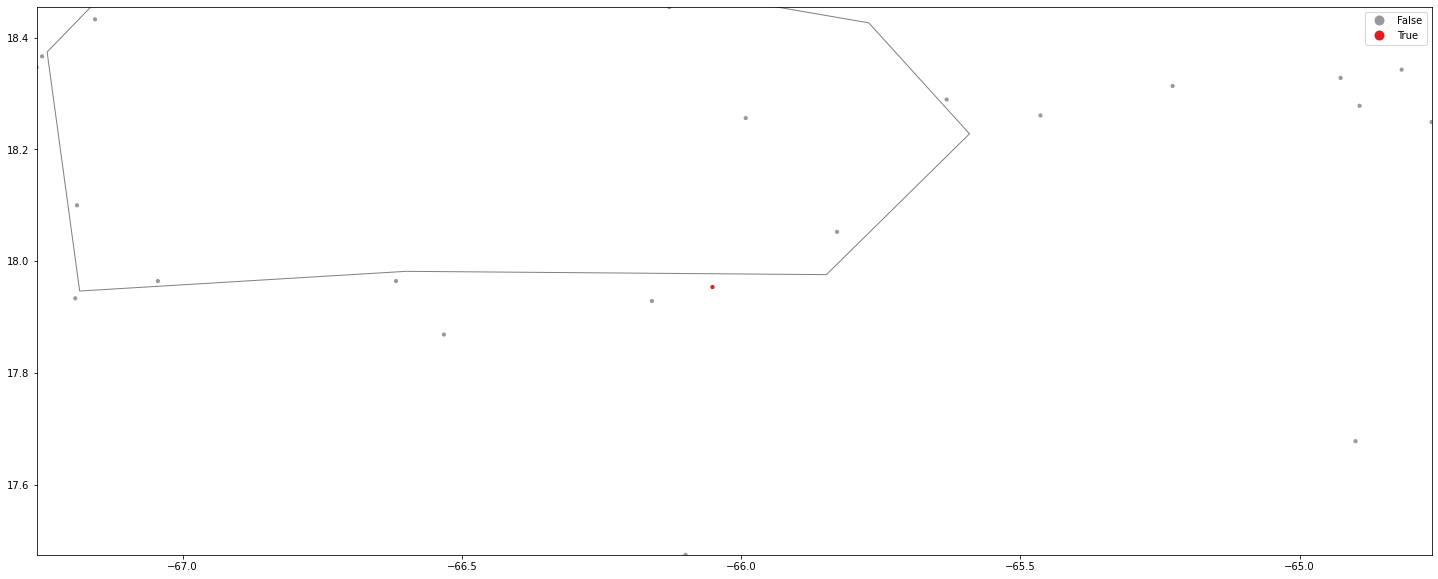

In [15]:
import geopandas
import matplotlib.pyplot as plt

#df = df.loc[df['']]

df.rename(columns=
{'Variable Names + water column depth of measurement in meters [CF_name (# m, # m) or CF_name (mult) or CF_name (# depths)].':
     'Variable Names',
 'Station Deployment (mm/yyyy, yyyy, < 5 yr, > 5 yr)': 'Station Deployment',
 'Longitude (dec deg)': 'Longitude',
 'Latitude (dec deg)': 'Latitude'},
              inplace=True)

df['Station Deployment'] = \
    df['Station Deployment'].astype(str)


gdf = geopandas.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(df['Longitude'], df['Latitude']))

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

ax = world.plot(
    color='white', 
    edgecolor='grey', 
    figsize=(25,20),
    )

gdf.plot( ax=ax,
         column='erddap_not_avail', 
         categorical=True, 
         cmap = 'Set1_r',
         markersize=10, 
         legend=True,
         k=2,
        )



minx, miny, maxx, maxy = gdf.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

plt.show()

In [16]:
gdf_final = gdf.set_crs(epsg=4326)

gdf_final.explore('erddap_not_avail',cmap = 'Set1_r',)

In [17]:
gdf_final.loc[gdf_final['geometry'].is_empty == True]

,Station ID,WMO ID or NWS/CMAN ID,Station Long Name,Station Description,Latitude,Longitude,Platform Type,Station Deployment,"Currently Operational? (Y, N, O, U)",Platform Funder/Sponsor,...,Platform Operator/Owner,Operator Sector,Platform Maintainer,Data Manager,Variable Names,Additional notes,CARICOOS Contact (Name and Email),RA/Federal Affiliation,erddap_not_avail,geometry


In [18]:
# import urllib.request
# for url in gdf_final.loc[gdf_final['erddap_not_avail'],'Station Description'].str.replace('url: ',''):
#     print(url)
#     try:
#         urllib.request.urlopen(url).getcode()
#     except:
#         print("URL broken: %s" % url)
#         print(gdf_final.loc[gdf_final['Station Description'].str.contains(url,regex=False),'Station ID'])

In [19]:
df.shape

(22, 21)

In [20]:
gdf_final['Station Description'].astype(str)

0                        nan
1                        nan
2                        nan
3                        nan
4     NCEI Accession 0117354
5                        nan
6                        nan
7                        nan
8                        nan
9                        nan
10                       nan
11                       nan
12                       nan
13                       nan
14                       nan
15                       nan
16                       nan
17                       nan
18                       nan
19                       nan
20                       nan
21                       nan
Name: Station Description, dtype: object